#### Goal: provide an accurate train occupancy rate forecasting

#### Observations

    The model has a overfitting problem. While the model is able to forcast with high accuracy with the training and testing split, it under performs on unseen data.

    Absolute Error benchmark: 0.0131
    Performance V1: 0.0234.

    Problems:
    The data its self is very biased.
    Stations should be a important feature, but the models feature importance shows that is has very little affect on the performance
    Hours is also a important feature, but the model feature importance shows that it has a heavy negative impact on the model

    TODO:
    Find another way to incorportate the station feature to make it have a higher importance
    Resolve why hour has such a high negative importance


#### Dataset Features

Contextual variables

    date d: YYYYMMDD is the date of the train id run
    train k: 1, 2, …, 55 train id (unique by day d)
    station s: AA, AB, AC,… is the station id
    hour: HH:00:00 is the time slot
    way: 0, 1 is the train way with 0 (toward Paris) or 1 (toward suburb)
    composition: 1, 2 is the number of train units (one or two)

Lags variables

    p1q0 ∈ [0,1] is the occupancy rate of the previous train k-1 at the same station s
    p2q0 ∈ [0,1] is the occupancy rate of the second previous train k-2 at the same station s
    p3q0 ∈ [0,1] is the occupancy rate of the third previous train k-3 at the same station s
    p0q1 ∈ [0,1] is the occupancy rate of the same train k at the previous station s-1
    p0q2 ∈ [0,1] is the occupancy rate of the same train k at the second previous station s-2
    p0q3 ∈ [0,1] is the occupancy rate of the same train k at the third previous station s-3

#### Library Import

In [35]:
import pandas as pd
import seaborn as sns
from pathlib import Path as path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import zscore

## Training Dataset

Missing Data

    date              0
    train             0
    way               0
    station           0
    hour           3204
    composition       0
    p1q0           2052
    p2q0           4145
    p3q0           6184
    p0q1           3202
    p0q2           6399
    p0q3           9592
    p0q0              0
    
Hour Size

    06:00:00     4995
    07:00:00    10064
    08:00:00    10028
    09:00:00     2826
    11:00:00        2

In [36]:
Xtrain = pd.read_csv(path('data/Xtrain.csv'))
Ytrain = pd.read_csv(path('data/Ytrain.csv'))
Ytrain = Ytrain.loc[:, ~Ytrain.columns.str.contains('^Unnamed')]
TrainData = Xtrain
TrainData = TrainData.merge(Ytrain, left_index= True, right_index= True)
print(TrainData.info())
TrainData

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         31119 non-null  object 
 1   train        31119 non-null  int64  
 2   way          31119 non-null  int64  
 3   station      31119 non-null  object 
 4   hour         27915 non-null  object 
 5   composition  31119 non-null  int64  
 6   p1q0         29067 non-null  float64
 7   p2q0         26974 non-null  float64
 8   p3q0         24935 non-null  float64
 9   p0q1         27917 non-null  float64
 10  p0q2         24720 non-null  float64
 11  p0q3         21527 non-null  float64
 12  p0q0         31119 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 3.1+ MB
None


,date,train,way,station,hour,composition,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,2019-01-07,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.201,0.138,0.091,0.216
1,2019-01-08,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.204,0.152,0.106,0.216
2,2019-01-10,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.153,0.111,0.227
3,2019-01-11,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.213,0.152,0.108,0.229
4,2019-01-14,1,0,AD,06:00:00,2,NaN,NaN,NaN,0.210,0.147,0.096,0.225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31114,2019-05-13,9,0,BE,08:00:00,2,0.152,0.18860,0.157000,0.080,0.100,NaN,0.111
31115,2019-05-14,9,0,BE,08:00:00,2,0.153,0.18040,0.191000,0.089,0.121,NaN,0.143
31116,2019-05-15,9,0,BE,08:00:00,2,0.166,0.14900,0.168000,0.099,0.129,NaN,0.139
31117,2019-03-21,9,0,BE,08:00:00,2,0.182,0.19300,0.162000,0.074,0.101,NaN,0.117


## Submission Dataset
Missing Data

    date              0
    train             0
    way               0
    station           0
    hour           1406
    composition       0
    p1q0            853
    p2q0           1745
    p3q0           2660
    p0q1           1400
    p0q2           2799
    p0q3           4196

Hour Size

    06:00:00    2122
    07:00:00    4583
    08:00:00    4370
    09:00:00    1271

In [37]:
submission = pd.read_csv(path('data/Xtest.csv'))
print(submission.isna().sum())
print(submission.groupby('hour').size())

date              0
train             0
way               0
station           0
hour           1406
composition       0
p1q0            853
p2q0           1745
p3q0           2660
p0q1           1400
p0q2           2799
p0q3           4196
dtype: int64
hour
06:00:00    2122
07:00:00    4583
08:00:00    4370
09:00:00    1271
dtype: int64


## Missing Data

    date              0
    train             0
    way               0
    station           0
    hour           3204
    composition       0
    p1q0           2052
    p2q0           4145
    p3q0           6184
    p0q1           3202
    p0q2           6399
    p0q3           9592
    p0q0              0

#### Handling P* Q* Missing Data

P* Q* missing data is filled with the median for now

In [39]:
# Fill P* Q* Values with 0
def update_pq_zero(df):
    df.loc[df['p1q0'].isna(), ['p1q0']] = 0
    df.loc[df['p2q0'].isna(), ['p2q0']] = 0
    df.loc[df['p3q0'].isna(), ['p3q0']] = 0
    df.loc[df['p0q1'].isna(), ['p0q1']] = 0
    df.loc[df['p0q2'].isna(), ['p0q2']] = 0
    df.loc[df['p0q3'].isna(), ['p0q3']] = 0
    return df

# Fill P* Q* Values with median of column
def update_pq_median(df):
    df.loc[df['p1q0'].isna(), ['p1q0']] = df['p1q0'].median()
    df.loc[df['p2q0'].isna(), ['p2q0']] = df['p2q0'].median()
    df.loc[df['p3q0'].isna(), ['p3q0']] = df['p3q0'].median()
    df.loc[df['p0q1'].isna(), ['p0q1']] = df['p0q1'].median()
    df.loc[df['p0q2'].isna(), ['p0q2']] = df['p0q2'].median()
    df.loc[df['p0q3'].isna(), ['p0q3']] = df['p0q3'].median()
    return df

#### Handling Hour Missing Data

hour
* 06:00:00     4995
* 07:00:00    10064
* 08:00:00    10028
* 09:00:00     2826
* 11:00:00        2

#### Handling Date and Time

To generalize the model better, we removed the date time since the test data dates are different then our training dates.

Currently, the hour feature has the highest negative impact on the model

TODO: Find a way to incorporate Nan hour and make the feature more meaningful nad have a positive inpact

In [40]:
# Drops date column
def update_date(df):
    df = df.drop('date',axis=1)
    return df

# Turns this column into a category type
def update_hour_cat(df):
    df.hour = df.hour.astype('category')
    return df

# Turns this column into a integear represention, but does not account for Nan
def update_hour(df):
    hour = pd.to_datetime(df['hour'], format='%H:%M:%S').dt.hour
    df['hour'] = hour
    return df

#### Handling Station

Initially Label encoded all stations, but this played little to no effect on the performance of the model.

TODO: One hot encode stations in an attempt to make them more positivly meaningful

In [41]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
def update_station(df):
    one_hot = LabelBinarizer().fit_transform(df.station)
    temp = []
    for _ in one_hot:
        temp.append(_)
    df['station'] = temp
    return df

def update_station_cat(df):
    df.station = df.station.astype('category')
    return df

def label_encode(param):
    LabelE = LabelEncoder()
    LabelE.fit(param)
    return LabelE.transform(param)


### Cleaned Dataframe

Incorporates all cleaning functions above into one function that takes a raw df and returns the cleaned version model ready

In [42]:
def clean_dataframe(df):
    # Dropping the below columns that we believe have little value and are also heavily biased
    df.drop('way',axis=1,inplace=True)
    df.drop('composition',axis=1,inplace=True)
    df.drop('train',axis=1,inplace=True)

    df = update_pq_median(df)
    df = update_date(df)
    df = update_hour_cat(df)
    df['hour'] = label_encode(df['hour'])
    df = update_station_cat(df)
    df['station'] = label_encode(df['station'])

    return df

In [43]:
model_df = TrainData.copy()
model_df = clean_dataframe(model_df)
print(model_df.info())
model_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31119 entries, 0 to 31118
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   station  31119 non-null  int64  
 1   hour     31119 non-null  int64  
 2   p1q0     31119 non-null  float64
 3   p2q0     31119 non-null  float64
 4   p3q0     31119 non-null  float64
 5   p0q1     31119 non-null  float64
 6   p0q2     31119 non-null  float64
 7   p0q3     31119 non-null  float64
 8   p0q0     31119 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 2.1 MB
None


,station,hour,p1q0,p2q0,p3q0,p0q1,p0q2,p0q3,p0q0
0,3,0,0.192,0.23000,0.312000,0.201,0.138,0.091,0.216
1,3,0,0.192,0.23000,0.312000,0.204,0.152,0.106,0.216
2,3,0,0.192,0.23000,0.312000,0.213,0.153,0.111,0.227
3,3,0,0.192,0.23000,0.312000,0.213,0.152,0.108,0.229
4,3,0,0.192,0.23000,0.312000,0.210,0.147,0.096,0.225
...,...,...,...,...,...,...,...,...,...
31114,30,2,0.152,0.18860,0.157000,0.080,0.100,0.172,0.111
31115,30,2,0.153,0.18040,0.191000,0.089,0.121,0.172,0.143
31116,30,2,0.166,0.14900,0.168000,0.099,0.129,0.172,0.139
31117,30,2,0.182,0.19300,0.162000,0.074,0.101,0.172,0.117


## XGBoost

In [44]:
import xgboost as xgb
import shap

# Initializes and returns xgboost model with provided hyperparameters
def xgboost_model(x_train, y_train, n_estimators=1000, max_depth=5,eta=.3):
    # n_estimates = number of trees to make prediction. Start small and increase until no improvement
    # max_depth = depth of the tree limiting the n_estimates level
    # eta = learning rate
    xgb_model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=eta, objective='reg:squarederror')
    xgb_model.fit(x_train,y_train)
    return xgb_model

# Given the model, x_test, y_test. Predict and measure using r2, mse, mae
def xgboost_prediction(xgb_model,x_test,y_test):
    y_prediction = xgb_model.predict(x_test)

    score = r2_score(y_test,y_prediction)
    mse = mean_squared_error(y_test, y_prediction)
    mae = mean_absolute_error(y_test,y_prediction)

    print(f'r2 score is:                {round(score,4)}    ->  %{round(score*100,4)}')
    print(f'Mean Square Error is:       {round(mse,4)}    ->  %{round(mse*100,4)}')
    print(f'Mean Absolute Error is:     {round(mae,4)}    ->  %{round(mae*100,4)}')

# Given the model and x_test. Return y_predictions dataframe
def xgboost_submission(xgb_model,x_test):
    y_prediction = xgb_model.predict(x_test)
    return y_prediction

# Plots the models feature importance
def xgboost_plot(model,Xtrain):
    shap_values = shap.TreeExplainer(model).shap_values(Xtrain)
    shap.summary_plot(shap_values,Xtrain)

r2 score is:                0.9831    ->  %98.3099
Mean Square Error is:       0.0004    ->  %0.0419
Mean Absolute Error is:     0.012    ->  %1.1977


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


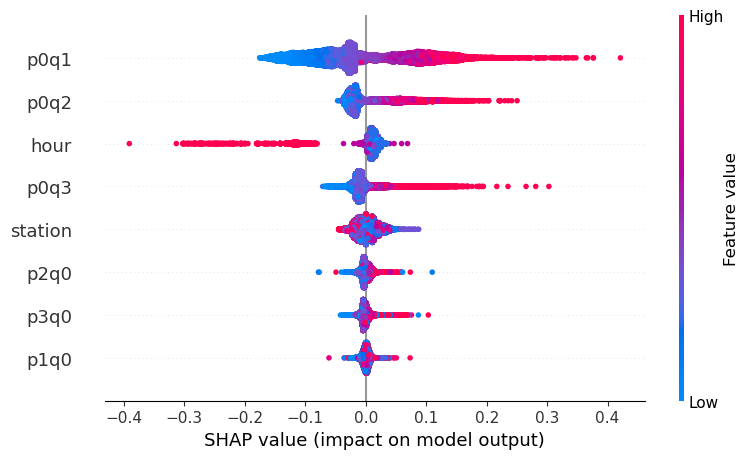

In [45]:
from sklearn.model_selection import train_test_split

model = model_df.copy()
columns = ['p0q0']
Xtrain = model.drop(columns=columns, axis=1)
Ytrain = model['p0q0']

# Stratify the hour column in hopes to have a better balance
x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size = 0.2, random_state = 42, stratify=Xtrain['hour'])

xgb_model = xgboost_model(x_train,y_train)
xgboost_prediction(xgb_model,x_test,y_test)
xgboost_plot(xgb_model,Xtrain)

r2 score is:                0.9851    ->  %98.5132
Mean Square Error is:       0.0004    ->  %0.0369
Mean Absolute Error is:     0.0112    ->  %1.1203


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


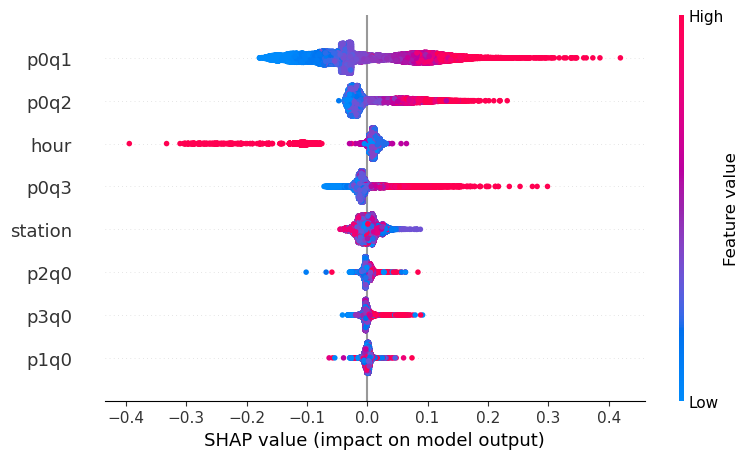

In [46]:
xgb_model = xgboost_model(x_train,y_train,n_estimators=5000,max_depth=6,eta=.05)
xgboost_prediction(xgb_model,x_test,y_test)
xgboost_plot(xgb_model,Xtrain)

In [47]:
temp = submission.copy()
temp = clean_dataframe(temp)

y_prediction = xgboost_submission(xgb_model,temp)

Ysample = pd.DataFrame(y_prediction, columns=['p0q0'])
Ysample['p0q0'] = Ysample['p0q0'].apply(lambda x: round(x,3))
Ysample.index = np.arange(1, len(Ysample) + 1)
Ysample.to_csv('Ysample.csv')